In [1]:
!uv pip install lightgbm optuna scikit-learn pandas matplotlib seaborn IProgress jupyter ipywidgets -U -q

In [ ]:
!uv pip install ../../target/wheels/perpetual-1.0.0-cp313-cp313-win_amd64.whl

Using Python 3.13.7 environment at: C:\work\perpetual\rust_project\forust-main-perp-oss\.venv
Audited 1 package in 6ms


In [3]:
import math
import optuna
import numpy as np
import pandas as pd
from functools import partial
from time import process_time, time
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, train_test_split, cross_validate
from perpetual import PerpetualBooster

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def get_data(data_path):
  data = pd.read_csv(data_path)
  X = data.drop('y', axis=1)
  y = data.y.apply(lambda x: 1 if x == 'yes' else 0)

  return X, y

In [ ]:
# https://archive.ics.uci.edu/dataset/222/bank+marketing

X_train, y_train = get_data('train_v2.csv')
X_test, y_test = get_data('test_v2.csv')

In [7]:
object_cols = X_train.select_dtypes(include=['object']).columns
X_train[object_cols] = X_train[object_cols].astype('category')
object_cols = X_test.select_dtypes(include=['object']).columns
X_test[object_cols] = X_test[object_cols].astype('category')

In [8]:
print(X_train.shape)
print(X_test.shape)

(32950, 20)
(8238, 20)


In [9]:
print(np.mean(y_train.values))
print(y_train.value_counts())
print(np.mean(y_test.values))
print(y_test.value_counts())

0.11265553869499241
y
0    29238
1     3712
Name: count, dtype: int64
0.11264870114105366
y
0    7310
1     928
Name: count, dtype: int64


In [10]:
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,25,blue-collar,single,high.school,no,yes,no,cellular,jul,mon,619,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
1,40,admin.,married,high.school,no,no,no,telephone,jun,thu,97,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1
2,51,technician,married,university.degree,no,yes,no,cellular,aug,wed,512,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
3,37,blue-collar,married,high.school,unknown,yes,no,cellular,jul,tue,423,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
4,54,housemaid,married,university.degree,unknown,yes,no,cellular,aug,thu,297,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32950 non-null  int64   
 1   job             32950 non-null  category
 2   marital         32950 non-null  category
 3   education       32950 non-null  category
 4   default         32950 non-null  category
 5   housing         32950 non-null  category
 6   loan            32950 non-null  category
 7   contact         32950 non-null  category
 8   month           32950 non-null  category
 9   day_of_week     32950 non-null  category
 10  duration        32950 non-null  int64   
 11  campaign        32950 non-null  int64   
 12  pdays           32950 non-null  int64   
 13  previous        32950 non-null  int64   
 14  poutcome        32950 non-null  category
 15  emp.var.rate    32950 non-null  float64 
 16  cons.price.idx  32950 non-null  float64 
 17  cons.conf.id

In [12]:
def prepare_data(seed):
    scoring = "neg_log_loss"
    metric_function = log_loss
    metric_name = "log_loss"

    return (
        X_train,
        X_test,
        y_train,
        y_test,
        scoring,
        metric_function,
        metric_name,
    )


def objective_function(trial, seed, n_estimators, X_train, y_train, scoring, cv):
    
    params = {
        "seed": seed,
        "verbosity": -1,
        "n_estimators": n_estimators,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 1e-6, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 33),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1024),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    model = LGBMClassifier(**params)

    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
    )

    trial.set_user_attr("models", cv_results["estimator"])

    return -1 * np.mean(cv_results["test_score"])

In [13]:
seed = 0
n_trials = 100
n_estimators = 100

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

(
    X_train,
    X_test,
    y_train,
    y_test,
    scoring,
    metric_function,
    metric_name,
) = prepare_data(seed)

sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction="minimize", sampler=sampler)

obj = partial(
    objective_function,
    seed=seed,
    n_estimators=n_estimators,
    X_train=X_train,
    y_train=y_train,
    scoring=scoring,
    cv=cv,
)

start = process_time()
tick = time()
study.optimize(obj, n_trials=n_trials)
stop = process_time()


print(f"seed: {seed}, cpu time: {stop - start}")

[I 2025-10-31 10:15:38,667] A new study created in memory with name: no-name-97adcfa8-4341-4c28-9c6d-d4d12e400309
[I 2025-10-31 10:15:46,744] Trial 0 finished with value: 0.18045682889414888 and parameters: {'learning_rate': 0.03028525153605885, 'min_split_gain': 0.019549524484259877, 'reg_alpha': 0.00413599739383989, 'reg_lambda': 0.0018590843630169633, 'colsample_bytree': 0.5389238394711238, 'subsample': 0.7167152904533249, 'subsample_freq': 5, 'max_depth': 30, 'num_leaves': 987, 'min_child_samples': 39}. Best is trial 0 with value: 0.18045682889414888.
[I 2025-10-31 10:15:51,403] Trial 1 finished with value: 0.18080822533999058 and parameters: {'learning_rate': 0.13703835270362635, 'min_split_gain': 0.0014906288366101645, 'reg_alpha': 0.002560161525002871, 'reg_lambda': 0.35775015430826956, 'colsample_bytree': 0.25682884655830956, 'subsample': 0.26970343976123257, 'subsample_freq': 1, 'max_depth': 28, 'num_leaves': 798, 'min_child_samples': 88}. Best is trial 0 with value: 0.1804568

seed: 0, cpu time: 4167.609375


In [14]:
study.best_trial.params

{'learning_rate': 0.08601674476064666,
 'min_split_gain': 0.9724839091021369,
 'reg_alpha': 1.3915335999907867e-05,
 'reg_lambda': 0.0008056676773329228,
 'colsample_bytree': 0.8905848182739692,
 'subsample': 0.9289046020168492,
 'subsample_freq': 1,
 'max_depth': 9,
 'num_leaves': 28,
 'min_child_samples': 27}

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay


params = study.best_trial.params
params["n_estimators"] = n_estimators
params["seed"] = seed
params["verbosity"] = -1
lgbm = LGBMClassifier(**params)
lgbm_isotonic = CalibratedClassifierCV(LGBMClassifier(**params), cv=cv, method="isotonic")
lgbm_sigmoid = CalibratedClassifierCV(LGBMClassifier(**params), cv=cv, method="sigmoid")

lgbm_models = [
    (lgbm, "LightGBM"),
    (lgbm_isotonic, "LightGBM + Isotonic"),
    (lgbm_sigmoid, "LightGBM + Sigmoid"),
]

In [16]:
n_bins = 10

In [17]:
import numpy as np
from typing import Union, Tuple, Sequence
from sklearn.calibration import calibration_curve


def expected_calibration_error(y_true: Union[np.ndarray, Sequence[int]], 
                               y_pred: Union[np.ndarray, Sequence[float]], 
                               n_bins: int = 10) -> Tuple[float, np.ndarray, np.ndarray]:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    N = len(y_true)

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins)
    bins = np.linspace(0., 1., n_bins + 1)
    counts, _ = np.histogram(y_pred, bins=bins, range=(0., 1.))
    non_empty_counts = counts[counts > 0]
    weights = non_empty_counts / N
    ece = np.sum(weights * np.abs(prob_true - prob_pred))

    return ece, prob_true, prob_pred, weights

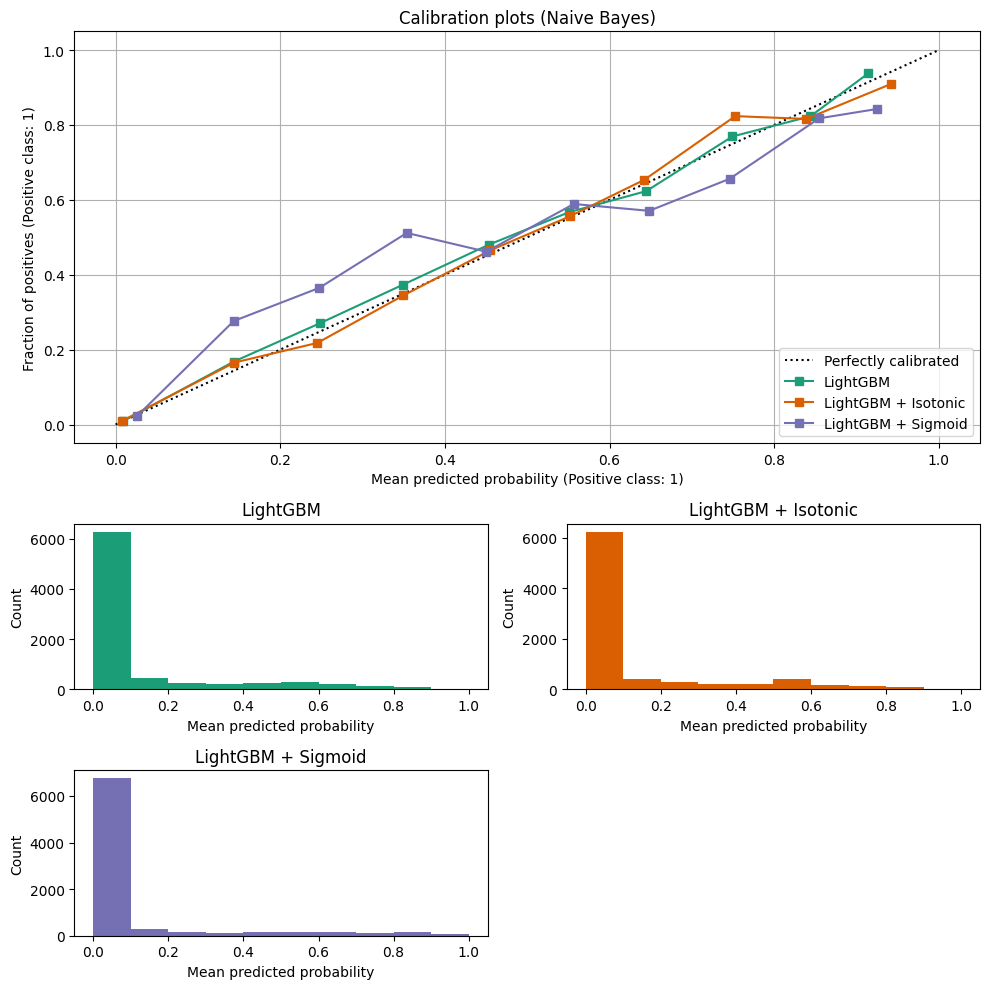

In [18]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(lgbm_models):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    display = CalibrationDisplay.from_predictions(
        y_test,
        y_pred,
        n_bins=n_bins,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(lgbm_models):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=n_bins,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [19]:
print(expected_calibration_error(y_test, lgbm_models[0][0].predict_proba(X_test)[:,1], n_bins))
print(expected_calibration_error(y_test, lgbm_models[1][0].predict_proba(X_test)[:,1], n_bins))
print(expected_calibration_error(y_test, lgbm_models[2][0].predict_proba(X_test)[:,1], n_bins))

(np.float64(0.005539556416334057), array([0.00893142, 0.16818182, 0.27075812, 0.37320574, 0.48      ,
       0.56721311, 0.62325581, 0.76923077, 0.82300885, 0.9375    ]), array([0.00923308, 0.14381031, 0.24859117, 0.34896075, 0.45314576,
       0.55112778, 0.6446378 , 0.74927351, 0.84396246, 0.91411211]), array([0.76110706, 0.05341102, 0.03362467, 0.02537024, 0.03034717,
       0.03702355, 0.02609857, 0.01735858, 0.01371692, 0.00194222]))
(np.float64(0.005840811903698297), array([0.0093083 , 0.16548463, 0.21782178, 0.34466019, 0.46511628,
       0.55581395, 0.65363128, 0.82352941, 0.81609195, 0.90909091]), array([0.0075688 , 0.14446194, 0.24504025, 0.3495734 , 0.45519004,
       0.55161852, 0.64238328, 0.75270039, 0.83885292, 0.94157098]), array([0.75637291, 0.05134741, 0.03678077, 0.02500607, 0.02609857,
       0.05219714, 0.02172857, 0.01857247, 0.01056082, 0.00133528]))
(np.float64(0.017816311372940725), array([0.02199911, 0.27636364, 0.36486486, 0.51162791, 0.46153846,
       0.588

In [20]:
lgbm_cal_classifiers = lgbm_models[1][0].calibrated_classifiers_
print(type(lgbm_cal_classifiers[0]))
print(len(lgbm_cal_classifiers))
print([d for d in dir(lgbm_cal_classifiers[0]) if not d.startswith("__")])

<class 'sklearn.calibration._CalibratedClassifier'>
5
['calibrators', 'classes', 'estimator', 'method', 'predict_proba']


In [ ]:
from sklearn.metrics import confusion_matrix


def business_objective(y_true, y_proba, threshold, benefit_tp=1000, cost_fp=100, cost_fn=500, verbose=False):
    """
    Calculates the net business value (profit) for a lead scoring model
    at a given probability threshold.

    This objective function quantifies the financial impact of the model's 
    classification decisions, maximizing:
    (TP * Benefit_TP) - (FP * Cost_FP) - (FN * Cost_FN)

    Inputs:
    - y_true (np.array): Ground truth labels (0 for bad lead, 1 for good lead).
    - y_proba (np.array): Predicted probabilities for the positive class (1).
    - threshold (float): The probability cutoff (e.g., 0.5) used to classify leads.
    - benefit_tp (float): Financial gain from a successful conversion (True Positive).
    - cost_fp (float): Financial cost of sales time wasted on a dead lead (False Positive).
    - cost_fn (float): Opportunity cost of a missed good lead (False Negative).
    
    Returns:
    - float: The total net business value achieved at this threshold.
    """
    
    # 1. Classify leads based on the threshold
    y_pred = (y_proba >= threshold).astype(int)
    
    # 2. Calculate the Confusion Matrix
    # cm format: [[TN, FP], [FN, TP]]
    # Ensure all inputs are NumPy arrays for safety
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Use try/except for robust matrix calculation
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        # Handle cases where the confusion matrix might have missing classes
        # This is rare but good for robustness.
        print("Error: Could not unpack confusion matrix. Check unique values in y_true and y_pred.")
        return -np.inf # Return negative infinity to indicate a bad result
    
    # 3. Calculate the Net Business Value (The Objective Function)
    
    # Value from True Positives (Successful Conversions)
    value_tp = tp * benefit_tp
    
    # Cost from False Positives (Wasted Sales Effort)
    cost_fp_total = fp * cost_fp
    
    # Cost from False Negatives (Lost Opportunity/Revenue)
    cost_fn_total = fn * cost_fn
    
    net_business_value = value_tp - cost_fp_total - cost_fn_total
    
    if verbose:
        print(f"--- Results for Threshold: {threshold:.4f} ---")
        print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
        print(f"TP Value: ${value_tp:,.2f} | FP Cost: ${cost_fp_total:,.2f} | FN Cost: ${cost_fn_total:,.2f}")
        print(f"Net Business Value: ${net_business_value:,.2f}")
        print("---------------------------------------")
    
    return net_business_value, 0

In [33]:
print(business_objective(y_test.values, lgbm_models[0][0].predict_proba(X_test)[:,1], threshold=0.5))

(np.int64(296800), 0)


In [34]:
for t in np.arange(0.01, 1.0, 0.01):
    profit, margin = business_objective(y_test.values, lgbm_models[1][0].predict_proba(X_test)[:,1], threshold=t)
    print(f"Threshold: {t:.2f}, Profit: {profit:.0f}, Margin: {margin:.2f}%")

Threshold: 0.01, Profit: 696900, Margin: 0.00%
Threshold: 0.02, Profit: 714700, Margin: 0.00%
Threshold: 0.03, Profit: 722200, Margin: 0.00%
Threshold: 0.04, Profit: 731100, Margin: 0.00%
Threshold: 0.05, Profit: 734100, Margin: 0.00%
Threshold: 0.06, Profit: 733200, Margin: 0.00%
Threshold: 0.07, Profit: 732200, Margin: 0.00%
Threshold: 0.08, Profit: 733700, Margin: 0.00%
Threshold: 0.09, Profit: 736400, Margin: 0.00%
Threshold: 0.10, Profit: 727300, Margin: 0.00%
Threshold: 0.11, Profit: 727300, Margin: 0.00%
Threshold: 0.12, Profit: 719000, Margin: 0.00%
Threshold: 0.13, Profit: 713400, Margin: 0.00%
Threshold: 0.14, Profit: 705900, Margin: 0.00%
Threshold: 0.15, Profit: 698200, Margin: 0.00%
Threshold: 0.16, Profit: 688400, Margin: 0.00%
Threshold: 0.17, Profit: 683000, Margin: 0.00%
Threshold: 0.18, Profit: 676300, Margin: 0.00%
Threshold: 0.19, Profit: 667800, Margin: 0.00%
Threshold: 0.20, Profit: 657600, Margin: 0.00%
Threshold: 0.21, Profit: 651400, Margin: 0.00%
Threshold: 0.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

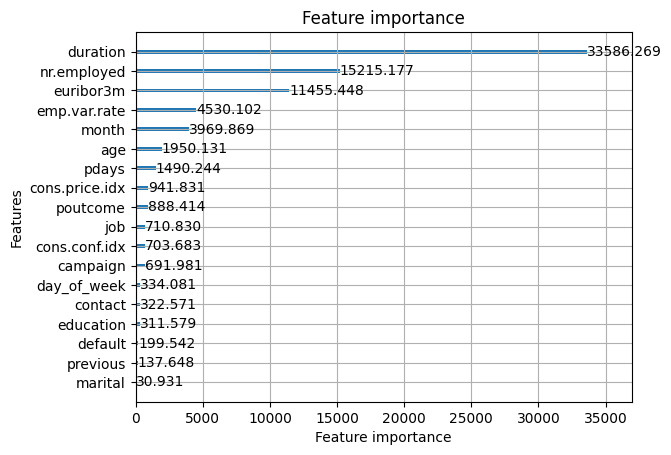

In [35]:
from lightgbm import plot_importance

plot_importance(lgbm_models[0][0], importance_type='gain')

In [36]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


y_proba_lgbm = np.mean([m.predict_proba(X_test)[:, 1] for m in lgbm_cal_classifiers], axis=0)

print(accuracy_score(y_test, np.rint(y_proba_lgbm)))
print(f1_score(y_test, np.rint(y_proba_lgbm)))
print(roc_auc_score(y_test, y_proba_lgbm))

0.9196406894877397
0.6297539149888143
0.9494948906788058


In [37]:
def get_leaf_nodes(perp: PerpetualBooster):
    return [{node.num: node for node in tree_nodes if node.is_leaf} for tree_nodes in perp.get_node_lists()]

In [38]:
def get_weights(leaf_nodes, pred_nodes):
  pred_weights = np.array([
      [
        [
              leaf_nodes[i][key].weights 
              for key in leaf_nodes[i].keys() & set(nodes)
        ][0]
          for nodes in tree_nodes
      ] 
      for i, tree_nodes in enumerate(pred_nodes)
  ])
  
  return np.sort(pred_weights, axis=2)

# Perpetual training

In [39]:
perp_models = []

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
    y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]
    perp = PerpetualBooster(budget=1.0, iteration_limit=10000)
    perp.fit(X_train_cv, y_train_cv)
    print(f"Number of trees: {perp.number_of_trees}")

    perp_models.append(perp)

Number of trees: 95
Number of trees: 92
Number of trees: 100
Number of trees: 88
Number of trees: 72


In [40]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


y_proba_perp = np.mean([m.predict_proba(X_test)[:, 1] for m in perp_models], axis=0)

print(accuracy_score(y_test, np.rint(y_proba_perp)))
print(f1_score(y_test, np.rint(y_proba_perp)))
print(roc_auc_score(y_test, y_proba_perp))

0.91854819130857
0.6031933767001774
0.9492726661634983


In [41]:
proba_ece = np.mean([m.predict_proba(X_test)[:, 1] for m in perp_models], axis=0)
print(expected_calibration_error(y_test, proba_ece, n_bins))

(np.float64(0.006580805086140705), array([0.01066539, 0.17943107, 0.2518797 , 0.39919355, 0.46396396,
       0.53558052, 0.63366337, 0.78395062, 0.83018868, 0.92307692]), array([0.00946544, 0.14645721, 0.24663679, 0.35113216, 0.44950636,
       0.55150116, 0.64582324, 0.74496308, 0.84877481, 0.91966004]), array([0.76256373, 0.05547463, 0.03228939, 0.03010439, 0.02694829,
       0.03241078, 0.02452051, 0.01966497, 0.0128672 , 0.00315611]))


In [42]:
perp_models[0].feature_importance_method

'Gain'

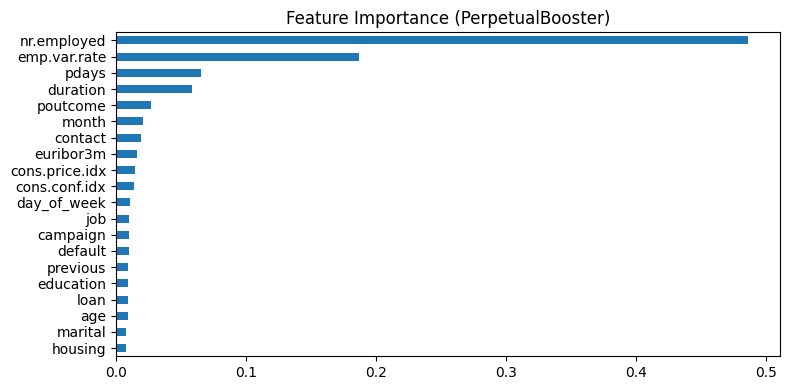

In [43]:
imp = pd.Series(perp_models[0].feature_importances_, index=perp_models[0].feature_names_in_).sort_values(ascending=False)
plt.figure(figsize=(8, 4))
imp.iloc[::-1].plot(kind='barh')
plt.title('Feature Importance (PerpetualBooster)')
plt.tight_layout()

In [44]:
X_test.shape

(8238, 20)

In [45]:
pred_weights = get_weights(get_leaf_nodes(perp), perp.predict_nodes(X_test))
pred_weights.shape

(72, 8238, 5)

In [46]:
pred_weights = get_weights(get_leaf_nodes(perp), perp.predict_nodes(X_test))
pred_lower = np.sum(np.min(pred_weights, axis=2), axis=0) + perp.base_score
pred_lower = 1.0 / (1.0 + np.exp(-pred_lower))
pred_lower.shape

(8238,)

In [47]:
pred_lower

array([0.24279855, 0.00114822, 0.00273588, ..., 0.01420016, 0.11661163,
       0.00129434], shape=(8238,))

In [48]:
pred_weights = get_weights(get_leaf_nodes(perp), perp.predict_nodes(X_test))
pred_upper = np.sum(np.max(pred_weights, axis=2), axis=0) + perp.base_score
pred_upper = 1.0 / (1.0 + np.exp(-pred_upper))
pred_upper.shape

(8238,)

In [49]:
pred_upper

array([0.51464552, 0.00144934, 0.00339108, ..., 0.02397784, 0.20467671,
       0.00155111], shape=(8238,))

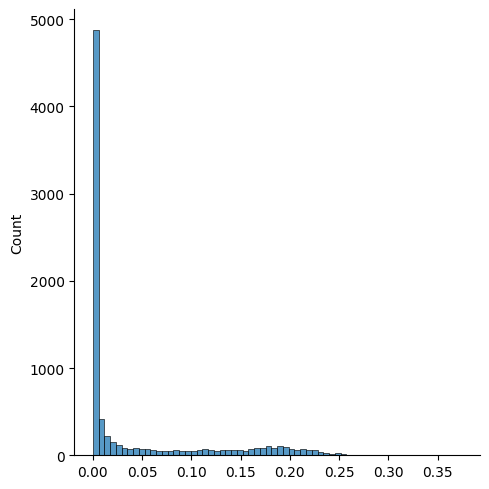

In [50]:
import seaborn as sns

sns.displot(pred_upper - pred_lower)

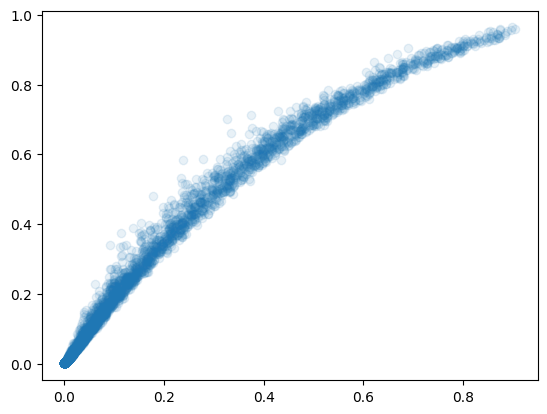

In [51]:
import matplotlib.pyplot as plt

plt.scatter(pred_lower, pred_upper, alpha=0.1)

In [52]:
max(pred_upper - pred_lower)

np.float64(0.3744013616528581)

In [53]:
pred_weights.shape

(72, 8238, 5)

In [54]:
n_simulations = 100

In [55]:
indices = np.random.randint(low=0, high=5, size=(pred_weights.shape[0], pred_weights.shape[1], n_simulations))
new_pred_weights = np.take_along_axis(pred_weights, indices, axis=2)
print(f"New array shape: {new_pred_weights.shape}")

New array shape: (72, 8238, 100)


In [56]:
new_pred_weights_sum = np.sum(new_pred_weights, axis=0) + perp.base_score
new_pred_weights_sum.shape

(8238, 100)

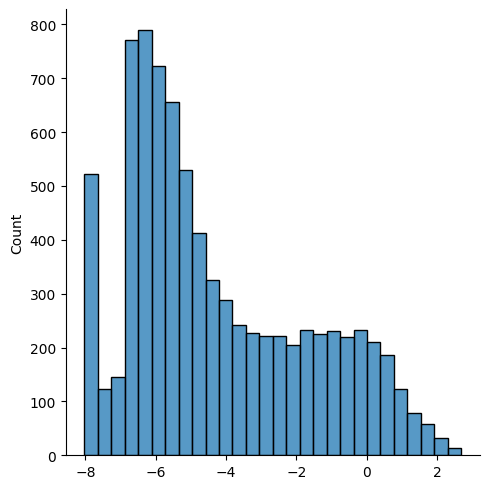

In [57]:
sns.displot(new_pred_weights_sum[:,90])

In [58]:
new_pred_weights_sum_proba = 1.0 / (1.0 + np.exp(-new_pred_weights_sum))
new_pred_weights_sum_proba.shape

(8238, 100)

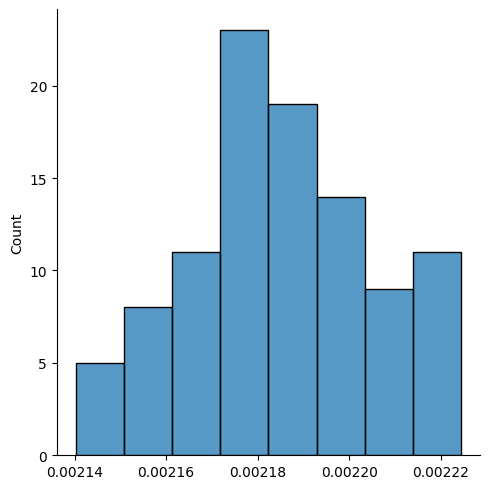

In [59]:
sns.displot(new_pred_weights_sum_proba[1100])

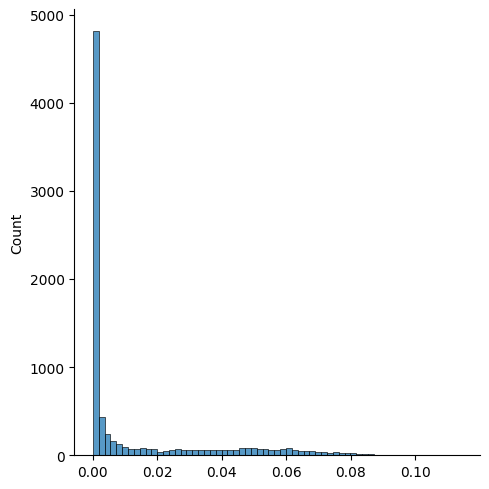

In [60]:
sns.displot(np.max(new_pred_weights_sum_proba, axis=1)-np.min(new_pred_weights_sum_proba, axis=1))

In [61]:
new_pred_weights_sum_proba.shape

(8238, 100)

In [62]:
def get_proba_sim(m_sim, X_sim, n_sim=100):
    pred_weights_sim = get_weights(get_leaf_nodes(m_sim), m_sim.predict_nodes(X_sim))
    indices_sim = np.random.randint(low=0, high=5, size=(pred_weights_sim.shape[0], pred_weights_sim.shape[1], n_sim))
    new_pred_weights_sim = np.take_along_axis(pred_weights_sim, indices_sim, axis=2)
    new_pred_weights_sum_sim = np.sum(new_pred_weights_sim, axis=0) + m_sim.base_score
    new_pred_weights_sum_proba_sim = 1.0 / (1.0 + np.exp(-new_pred_weights_sum_sim))
    
    return new_pred_weights_sum_proba_sim

In [63]:
def objective_t(trial):
    t = trial.suggest_float("threshold", 0.0, 0.3)
    
    profits = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        y_pred_sim = get_proba_sim(perp_models[i], X_test_cv, n_simulations)

        profits_fold = []
        for j in range(n_simulations):
            profit, margin = business_objective(y_test_cv.values, y_pred_sim[:,j], threshold=t)
            profits_fold.append(profit)
            
    profits.append(profits_fold)

    return np.mean(np.array(profits).flatten())

In [64]:
sampler_t = optuna.samplers.TPESampler(seed=seed)
study_t = optuna.create_study(direction="maximize", sampler=sampler_t)
study_t.optimize(objective_t, n_trials=10)

[I 2025-10-31 10:31:31,236] A new study created in memory with name: no-name-ad6526f4-ec31-4018-aa26-413b602f1841
[I 2025-10-31 10:31:45,866] Trial 0 finished with value: 548691.0 and parameters: {'threshold': 0.16464405117819741}. Best is trial 0 with value: 548691.0.
[I 2025-10-31 10:32:00,856] Trial 1 finished with value: 514523.0 and parameters: {'threshold': 0.21455680991172585}. Best is trial 0 with value: 548691.0.
[I 2025-10-31 10:32:35,806] Trial 2 finished with value: 541594.0 and parameters: {'threshold': 0.18082901282149316}. Best is trial 0 with value: 548691.0.
[I 2025-10-31 10:33:25,112] Trial 3 finished with value: 549587.0 and parameters: {'threshold': 0.16346495489906906}. Best is trial 3 with value: 549587.0.
[I 2025-10-31 10:33:49,986] Trial 4 finished with value: 571021.0 and parameters: {'threshold': 0.1270964398016714}. Best is trial 4 with value: 571021.0.
[I 2025-10-31 10:34:04,016] Trial 5 finished with value: 533777.0 and parameters: {'threshold': 0.193768233

In [65]:
study_t.best_trial.params["threshold"]

0.1150324556477333

In [66]:
y_proba = np.mean([m.predict_proba(X_test)[:, 1] for m in perp_models], axis=0)
profit, margin = business_objective(y_test.values, y_proba, threshold=study_t.best_trial.params["threshold"])
print(f"Profit: {profit}, Margin: {margin}%")

Profit: 710900, Margin: 0%


# Optimize threshold and weight index together

In [67]:
model_pred_weights = []
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
    y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test] 
    pred_weights = get_weights(get_leaf_nodes(perp_models[i]), perp_models[i].predict_nodes(X_test_cv))
    model_pred_weights.append(pred_weights)

In [68]:
# pred_weights.shape = (n_trees, n_samples, 5)

In [69]:
def get_proba_from_weights(p_weights, w, b_score):

    cal_weight, w_i_lower = math.modf(w)
    w_i_lower = int(w_i_lower)
    w_i_upper = w_i_lower + 1

    weights_lower = np.sum(p_weights[:, :, w_i_lower], axis=0) + b_score
    weights_upper = np.sum(p_weights[:, :, w_i_upper], axis=0) + b_score

    weighted = weights_lower * (1 - cal_weight) + weights_upper * cal_weight

    y_proba = 1.0 / (1.0 + np.exp(-weighted))

    return y_proba

In [70]:
def objective_w(trial):
    t = trial.suggest_float("threshold", 0.0, 0.3)
    w = trial.suggest_float("weight_index", 0.0, 4.0)
    
    profits = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        y_proba = get_proba_from_weights(model_pred_weights[i], w, perp_models[i].base_score)

        profit, margin = business_objective(y_test_cv.values, y_proba, threshold=t, verbose=False)
            
    profits.append(profit)

    return np.mean(profits)

In [71]:
sampler_w = optuna.samplers.TPESampler(seed=seed)
study_w = optuna.create_study(direction="maximize", sampler=sampler_w)
study_w.optimize(objective_w, n_trials=1000)

[I 2025-10-31 10:35:10,263] A new study created in memory with name: no-name-298cd143-fac3-43f9-9d5f-d1958b8f60c3
[I 2025-10-31 10:35:10,371] Trial 0 finished with value: 558200.0 and parameters: {'threshold': 0.16464405117819741, 'weight_index': 2.860757465489678}. Best is trial 0 with value: 558200.0.
[I 2025-10-31 10:35:10,431] Trial 1 finished with value: 546400.0 and parameters: {'threshold': 0.18082901282149316, 'weight_index': 2.1795327319875875}. Best is trial 0 with value: 558200.0.
[I 2025-10-31 10:35:10,483] Trial 2 finished with value: 581300.0 and parameters: {'threshold': 0.1270964398016714, 'weight_index': 2.5835764522666245}. Best is trial 2 with value: 581300.0.
[I 2025-10-31 10:35:10,538] Trial 3 finished with value: 587700.0 and parameters: {'threshold': 0.13127616337880774, 'weight_index': 3.567092003128319}. Best is trial 3 with value: 587700.0.
[I 2025-10-31 10:35:10,585] Trial 4 finished with value: 437900.0 and parameters: {'threshold': 0.2890988281503088, 'weig

In [72]:
study_w.best_trial.params

{'threshold': 0.07646291258309498, 'weight_index': 3.139775991069967}

In [73]:
y_proba = np.mean([get_proba_from_weights(get_weights(get_leaf_nodes(m), m.predict_nodes(X_test)), study_w.best_trial.params["weight_index"], m.base_score) for m in perp_models], axis=0)
profit_w, margin_w = business_objective(y_test.values, y_proba, threshold=study_w.best_trial.params["threshold"], verbose=False)
print(f"Profit: {profit_w}, Margin: {margin_w}%")

Profit: 740700, Margin: 0%


# Optimize business objective with calibrated LightGBM classifiers

In [74]:
best_threshold = 0
best_profit = 0

for t in np.arange(0.01, 0.5, 0.01):

    profits = []
    margins = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        m = lgbm_cal_classifiers[i]
        y_proba = m.predict_proba(X_test_cv)[:, 1]
        
        profit, margin = business_objective(y_test_cv.values, y_proba, threshold=t, verbose=False)
        profits.append(profit)
        margins.append(margin)

    if np.mean(profits) >= best_profit:
        best_profit = np.mean(profits)
        best_threshold = t

    print(f"Threshold: {t:.3f}, Profit: {np.mean(profits):.0f}, Margin: {np.mean(margins):.2f}%")

print(f"Best threshold: {best_threshold:.3f}, Best profit: {best_profit:.0f}")

Threshold: 0.010, Profit: 567300, Margin: 0.00%
Threshold: 0.020, Profit: 583380, Margin: 0.00%
Threshold: 0.030, Profit: 590380, Margin: 0.00%
Threshold: 0.040, Profit: 595440, Margin: 0.00%
Threshold: 0.050, Profit: 598440, Margin: 0.00%
Threshold: 0.060, Profit: 599320, Margin: 0.00%
Threshold: 0.070, Profit: 598900, Margin: 0.00%
Threshold: 0.080, Profit: 597660, Margin: 0.00%
Threshold: 0.090, Profit: 597580, Margin: 0.00%
Threshold: 0.100, Profit: 594560, Margin: 0.00%
Threshold: 0.110, Profit: 594560, Margin: 0.00%
Threshold: 0.120, Profit: 590420, Margin: 0.00%
Threshold: 0.130, Profit: 585660, Margin: 0.00%
Threshold: 0.140, Profit: 572680, Margin: 0.00%
Threshold: 0.150, Profit: 571560, Margin: 0.00%
Threshold: 0.160, Profit: 571560, Margin: 0.00%
Threshold: 0.170, Profit: 570560, Margin: 0.00%
Threshold: 0.180, Profit: 568940, Margin: 0.00%
Threshold: 0.190, Profit: 566620, Margin: 0.00%
Threshold: 0.200, Profit: 548440, Margin: 0.00%
Threshold: 0.210, Profit: 538000, Margin

In [75]:
y_proba = np.mean([m.predict_proba(X_test)[:, 1] for m in lgbm_cal_classifiers], axis=0)
profit_l, margin_l = business_objective(y_test.values, y_proba, threshold=best_threshold, verbose=False)
print(f"Profit: {profit_l}, Margin: {margin_l}")

Profit: 733200, Margin: 0


In [76]:
for t in np.arange(0.01, 0.5, 0.01):
    y_proba = np.mean([m.predict_proba(X_test)[:, 1] for m in lgbm_cal_classifiers], axis=0)
    profit_l_test, margin_l_test = business_objective(y_test.values, y_proba, threshold=t, verbose=False)
    print(f"Threshold: {t:.2f}, Profit: {profit_l_test}, Margin: {margin_l_test}")

Threshold: 0.01, Profit: 696900, Margin: 0
Threshold: 0.02, Profit: 714700, Margin: 0
Threshold: 0.03, Profit: 722200, Margin: 0
Threshold: 0.04, Profit: 731100, Margin: 0
Threshold: 0.05, Profit: 734100, Margin: 0
Threshold: 0.06, Profit: 733200, Margin: 0
Threshold: 0.07, Profit: 732200, Margin: 0
Threshold: 0.08, Profit: 733700, Margin: 0
Threshold: 0.09, Profit: 736400, Margin: 0
Threshold: 0.10, Profit: 727300, Margin: 0
Threshold: 0.11, Profit: 727300, Margin: 0
Threshold: 0.12, Profit: 719000, Margin: 0
Threshold: 0.13, Profit: 713400, Margin: 0
Threshold: 0.14, Profit: 705900, Margin: 0
Threshold: 0.15, Profit: 698200, Margin: 0
Threshold: 0.16, Profit: 688400, Margin: 0
Threshold: 0.17, Profit: 683000, Margin: 0
Threshold: 0.18, Profit: 676300, Margin: 0
Threshold: 0.19, Profit: 667800, Margin: 0
Threshold: 0.20, Profit: 657600, Margin: 0
Threshold: 0.21, Profit: 651400, Margin: 0
Threshold: 0.22, Profit: 636600, Margin: 0
Threshold: 0.23, Profit: 630300, Margin: 0
Threshold: 

In [77]:
print(((profit_w - profit_l) / abs(profit_l)) * 100)

1.0229132569558101


# Optimize threshold, weight index, budget together

In [78]:
budget_list = [0.1, 0.2, 0.3, 0.5, 1.0, 1.5, 2.0]

In [79]:
p_models = []
model_pred_weights = []
for budget in budget_list:
    cv_pred_weights = []
    p_models_cv = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]
        m = PerpetualBooster(budget=budget, iteration_limit=10000)
        m.fit(X_train_cv, y_train_cv)
        pred_weights = get_weights(get_leaf_nodes(m), m.predict_nodes(X_test_cv))
        cv_pred_weights.append(pred_weights)
        p_models_cv.append(m)
        print(f"Budget: {budget}, Fold: {i}, Number of trees: {m.number_of_trees}")
    print()
    p_models.append(p_models_cv)
    model_pred_weights.append(cv_pred_weights)

Budget: 0.1, Fold: 0, Number of trees: 60
Budget: 0.1, Fold: 1, Number of trees: 35
Budget: 0.1, Fold: 2, Number of trees: 73
Budget: 0.1, Fold: 3, Number of trees: 44
Budget: 0.1, Fold: 4, Number of trees: 40

Budget: 0.2, Fold: 0, Number of trees: 48
Budget: 0.2, Fold: 1, Number of trees: 33
Budget: 0.2, Fold: 2, Number of trees: 57
Budget: 0.2, Fold: 3, Number of trees: 37
Budget: 0.2, Fold: 4, Number of trees: 48

Budget: 0.3, Fold: 0, Number of trees: 42
Budget: 0.3, Fold: 1, Number of trees: 42
Budget: 0.3, Fold: 2, Number of trees: 61
Budget: 0.3, Fold: 3, Number of trees: 43
Budget: 0.3, Fold: 4, Number of trees: 32

Budget: 0.5, Fold: 0, Number of trees: 42
Budget: 0.5, Fold: 1, Number of trees: 40
Budget: 0.5, Fold: 2, Number of trees: 54
Budget: 0.5, Fold: 3, Number of trees: 42
Budget: 0.5, Fold: 4, Number of trees: 33

Budget: 1.0, Fold: 0, Number of trees: 95
Budget: 1.0, Fold: 1, Number of trees: 92
Budget: 1.0, Fold: 2, Number of trees: 100
Budget: 1.0, Fold: 3, Number 

In [80]:
budget_index_min = 0
for i, b in enumerate(budget_list):
    if i == 0:
        continue
    cv_models_prev = p_models[i-1]
    cv_models = p_models[i]
    min_diff_n_trees = min([cv_models[j].number_of_trees - cv_models_prev[j].number_of_trees for j in range(len(cv_models))])
    if min_diff_n_trees < 0:
        budget_index_min = i
    print(f"i: {i}, budget: {b}, previous budget n_trees: {[cv_models_prev[j].number_of_trees for j in range(len(cv_models_prev))]}, current budget n_trees: {[cv_models[j].number_of_trees for j in range(len(cv_models))]}, min_diff_n_trees: {min_diff_n_trees}")

print(f"Minimum budget index without tree count regression: {budget_index_min}")

i: 1, budget: 0.2, previous budget n_trees: [60, 35, 73, 44, 40], current budget n_trees: [48, 33, 57, 37, 48], min_diff_n_trees: -16
i: 2, budget: 0.3, previous budget n_trees: [48, 33, 57, 37, 48], current budget n_trees: [42, 42, 61, 43, 32], min_diff_n_trees: -16
i: 3, budget: 0.5, previous budget n_trees: [42, 42, 61, 43, 32], current budget n_trees: [42, 40, 54, 42, 33], min_diff_n_trees: -7
i: 4, budget: 1.0, previous budget n_trees: [42, 40, 54, 42, 33], current budget n_trees: [95, 92, 100, 88, 72], min_diff_n_trees: 39
i: 5, budget: 1.5, previous budget n_trees: [95, 92, 100, 88, 72], current budget n_trees: [289, 256, 256, 258, 205], min_diff_n_trees: 133
i: 6, budget: 2.0, previous budget n_trees: [289, 256, 256, 258, 205], current budget n_trees: [763, 672, 751, 692, 614], min_diff_n_trees: 409
Minimum budget index without tree count regression: 3


In [81]:
def objective_b(trial):
    t = trial.suggest_float("threshold", 0.0, 0.3)
    w = trial.suggest_float("weight_index", 0.0, 4.0)
    b = trial.suggest_categorical("budget_index", list(range(budget_index_min, len(budget_list), 1)))
    
    profits = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        y_proba = get_proba_from_weights(model_pred_weights[b][i], w, p_models[b][i].base_score)

        profit, margin = business_objective(y_test_cv.values, y_proba, threshold=t, verbose=False)
            
    profits.append(profit)

    return np.mean(profits)

In [82]:
sampler_b = optuna.samplers.TPESampler(seed=seed)
study_b = optuna.create_study(direction="maximize", sampler=sampler_b)
study_b.optimize(objective_b, n_trials=1000)

[I 2025-10-31 10:44:13,274] A new study created in memory with name: no-name-bddc8f1a-38ad-40a4-835c-e70d910c42db
[I 2025-10-31 10:44:13,486] Trial 0 finished with value: 552200.0 and parameters: {'threshold': 0.16464405117819741, 'weight_index': 2.860757465489678, 'budget_index': 6}. Best is trial 0 with value: 552200.0.
[I 2025-10-31 10:44:13,532] Trial 1 finished with value: 571800.0 and parameters: {'threshold': 0.13127616337880774, 'weight_index': 3.567092003128319, 'budget_index': 3}. Best is trial 1 with value: 571800.0.
[I 2025-10-31 10:44:13,710] Trial 2 finished with value: 570600.0 and parameters: {'threshold': 0.1704133683281797, 'weight_index': 3.702386553170644, 'budget_index': 6}. Best is trial 1 with value: 571800.0.
[I 2025-10-31 10:44:13,747] Trial 3 finished with value: 535700.0 and parameters: {'threshold': 0.23344702528495515, 'weight_index': 3.4800485929872766, 'budget_index': 3}. Best is trial 1 with value: 571800.0.
[I 2025-10-31 10:44:13,809] Trial 4 finished w

In [83]:
study_b.best_trial.params

{'threshold': 0.08700719777027546,
 'weight_index': 3.9041582272322826,
 'budget_index': 4}

In [84]:
budget_list[study_b.best_trial.params["budget_index"]]

1.0

In [85]:
y_proba = np.mean([get_proba_from_weights(get_weights(get_leaf_nodes(m), m.predict_nodes(X_test)), study_b.best_trial.params["weight_index"], m.base_score) for m in p_models[study_b.best_trial.params["budget_index"]]], axis=0)
profit_b, margin_b = business_objective(y_test.values, y_proba, threshold=study_b.best_trial.params["threshold"], verbose=False)
print(f"Profit: {profit_b}, Margin: {margin_b}%")

Profit: 740600, Margin: 0%


In [86]:
y_proba = np.mean([get_proba_from_weights(get_weights(get_leaf_nodes(m), m.predict_nodes(X_test)), study_b.best_trial.params["weight_index"], m.base_score) for m in p_models[study_b.best_trial.params["budget_index"]]], axis=0)
for t in np.arange(0.01, 0.5, 0.01):
    profit_b_test, margin_b_test = business_objective(y_test.values, y_proba, threshold=t, verbose=False)
    print(f"Threshold: {t:.2f}, Profit: {profit_b_test}, Margin: {margin_b_test}%")

Threshold: 0.01, Profit: 662700, Margin: 0%
Threshold: 0.02, Profit: 694000, Margin: 0%
Threshold: 0.03, Profit: 710500, Margin: 0%
Threshold: 0.04, Profit: 721700, Margin: 0%
Threshold: 0.05, Profit: 728000, Margin: 0%
Threshold: 0.06, Profit: 731800, Margin: 0%
Threshold: 0.07, Profit: 737500, Margin: 0%
Threshold: 0.08, Profit: 740900, Margin: 0%
Threshold: 0.09, Profit: 742000, Margin: 0%
Threshold: 0.10, Profit: 740900, Margin: 0%
Threshold: 0.11, Profit: 738800, Margin: 0%
Threshold: 0.12, Profit: 733700, Margin: 0%
Threshold: 0.13, Profit: 722900, Margin: 0%
Threshold: 0.14, Profit: 720300, Margin: 0%
Threshold: 0.15, Profit: 721600, Margin: 0%
Threshold: 0.16, Profit: 717400, Margin: 0%
Threshold: 0.17, Profit: 711500, Margin: 0%
Threshold: 0.18, Profit: 700300, Margin: 0%
Threshold: 0.19, Profit: 692700, Margin: 0%
Threshold: 0.20, Profit: 684000, Margin: 0%
Threshold: 0.21, Profit: 677900, Margin: 0%
Threshold: 0.22, Profit: 674400, Margin: 0%
Threshold: 0.23, Profit: 666500,

In [87]:
print(((profit_b - profit_l) / abs(profit_l)) * 100)

1.0092744135297327


In [88]:
# LightGBM n_estimators = 100
# 0.1 -> 1010250 -> -4.05428401259253
# 0.2 -> 989250  -> -2.7184548625882754
# 0.3 -> 987000  -> -8.580787883944526
# 0.5 -> 1135000 -> -4.479707308772228
# 1.0 -> 1046250 -> -0.22547434697524038
# 1.5 -> 1052000 -> 1.3060495192716752
# 2.0 -> 1073500 -> 1.9016421339232537
# 2.5 -> 1072500 -> -0.6041010805751723

In [89]:
# LightGBM n_estimators = 1000
# 2.0 -> 1074250 -> 1.131326776140825